In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# This code is smarter. It checks for the correct path.
train_path_option1 = 'data/train.csv'
train_path_option2 = '../data/train.csv'

if os.path.exists(train_path_option1):
    train_path = train_path_option1
    test_path = 'data/test.csv'
else:
    train_path = train_path_option2
    test_path = '../data/test.csv'

print(f"✅ Found data at: {train_path}")

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("\n--- Training Data Info ---")
train_df.info()

print("\n--- Training Data Head ---")
display(train_df.head())

✅ Found data at: ../data/train.csv

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB

--- Training Data Head ---


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


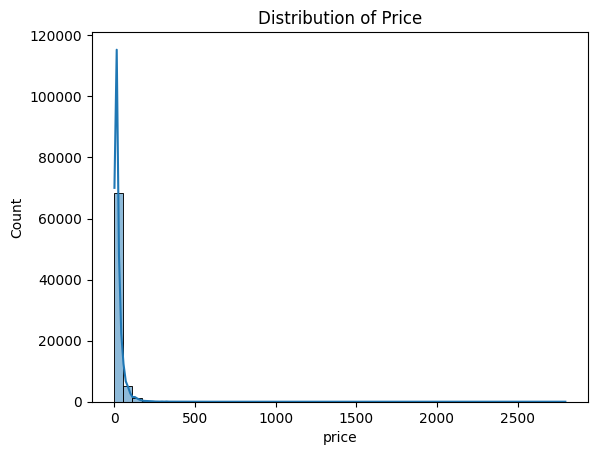

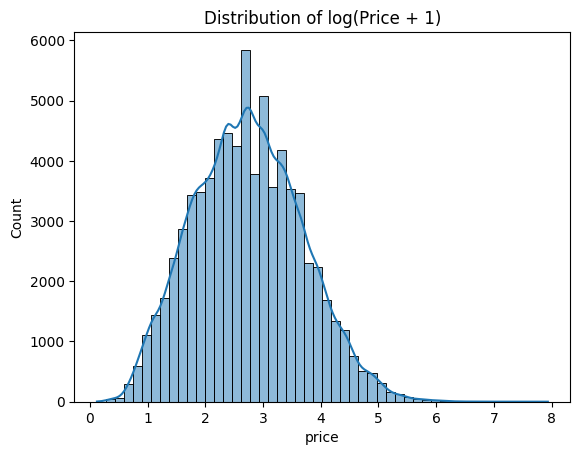

In [4]:
# Check the distribution of the price
sns.histplot(train_df['price'], kde=True, bins=50)
plt.title('Distribution of Price')
plt.show()

# It's likely right-skewed. Let's check the log distribution.
# np.log1p(x) is a safe way to calculate log(1+x)
sns.histplot(np.log1p(train_df['price']), kde=True, bins=50)
plt.title('Distribution of log(Price + 1)')
plt.show()

In [12]:
import re

def extract_brand(text):
    if not isinstance(text, str) or len(text) == 0:
        return "unknown"
    # A simple way to guess the brand is to take the first word.
    return text.split()[0].lower()

# Create the 'brand' column
train_df['brand'] = train_df['catalog_content'].apply(extract_brand)
test_df['brand'] = test_df['catalog_content'].apply(extract_brand)

# Tell pandas that 'brand' is a categorical feature
train_df['brand'] = train_df['brand'].astype('category')
test_df['brand'] = test_df['brand'].astype('category')

print("✅ Brand feature created successfully!")
display(train_df[['catalog_content', 'brand']].head())

✅ Brand feature created successfully!


,catalog_content,brand
0,"Item Name: La Victoria Green Taco Sauce Mild, ...",item
1,"Item Name: Salerno Cookies, The Original Butte...",item
2,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",item
3,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,item
4,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",item


In [15]:
import re

def extract_ipq(text):
    # This function uses a regular expression (regex) to find patterns
    # like 'Pack of 6', '32 oz', '12 count', etc.
    if not isinstance(text, str):
        return 1.0 # Handle non-string inputs just in case

    # This regex looks for a number followed by common units for quantity or weight
    match = re.search(r'(\d+\.?\d*)\s*(?:oz|ounce|count|pk|pack|fl oz|ct)', text, re.IGNORECASE)
    
    if match:
        # If a match is found, we return the number we found
        return float(match.group(1))
    
    # If no pack size is found, we assume it's a single item (quantity of 1)
    return 1.0 

# this function to create a new 'ipq' column in both dataframes
train_df['ipq'] = train_df['catalog_content'].apply(extract_ipq)
test_df['ipq'] = test_df['catalog_content'].apply(extract_ipq)

print("✅ IPQ feature created successfully!")
print("Here's a sample of the new feature:")

# Display the original text and the number that was extracted to see how it worked
display(train_df[['catalog_content', 'ipq']].head(10))

✅ IPQ feature created successfully!
Here's a sample of the new feature:


,catalog_content,ipq
0,"Item Name: La Victoria Green Taco Sauce Mild, ...",12.00
1,"Item Name: Salerno Cookies, The Original Butte...",8.00
2,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.90
3,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,11.25
4,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",12.70
5,"Item Name: Member's Mark Member's Mark, Basil,...",6.25
6,Item Name: Goya Foods Sazonador Total Seasonin...,30.00
7,Item Name: VineCo Original Series Chilean Sauv...,1.00
8,Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...,32.00
9,Item Name: Mrs. Miller's Seedless Black Raspbe...,9.00


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# --- Define the SMAPE Metric ---
# This is the official evaluation metric for the hackathon
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Add a small value to the denominator to avoid division by zero
    denominator[denominator == 0] = 1e-6 
    return np.mean(numerator / denominator) * 100

# --- Preprocessing ---
# Handle potential missing values in catalog_content, just in case
train_df['catalog_content'] = train_df['catalog_content'].fillna('')
test_df['catalog_content'] = test_df['catalog_content'].fillna('')

# Define features (X) and our log-transformed target (y_log)
X = train_df['catalog_content']
y_log = np.log1p(train_df['price'])

# Split data for validation to see how well our model is doing
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)

# --- Model Pipeline ---
# This pipeline chains our text vectorizer and our model together
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=25000, ngram_range=(1, 2))),
    ('lgbm', lgb.LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31))
])

# --- Training ---
print("🚀 Training the baseline model...")
pipeline.fit(X_train, y_train_log)

# --- Evaluation ---
print("📈 Evaluating the model...")
# Predict on the validation set
preds_log = pipeline.predict(X_val)

#  Convert predictions and true values back from log scale for SMAPE calculation
preds = np.expm1(preds_log)
y_val_true = np.expm1(y_val_log)

# Ensure all predicted prices are positive
preds[preds < 0] = 0

# Calculate SMAPE score
validation_smape = smape(y_val_true, preds)
print(f"\n✅ Validation SMAPE Score: {validation_smape:.4f}%")

🚀 Training the baseline model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.817319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205319
[LightGBM] [Info] Number of data points in the train set: 63750, number of used features: 24221
[LightGBM] [Info] Start training from score 2.740886
📈 Evaluating the model...

✅ Validation SMAPE Score: 54.8584%


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
# --- Imports for this specific model ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # <-- This was the missing import!
import lightgbm as lgb
import numpy as np

# --- 1. Define the Preprocessor ---
# This object will apply different transformations to different columns
numeric_features = ['ipq']
text_feature = 'catalog_content'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(stop_words='english', max_features=25000, ngram_range=(1, 2)), text_feature)
    ])

# --- 2. Create the Full Model Pipeline ---
model_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgb.LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31))
])

# --- 3. Train and Evaluate the New Model ---
# X now needs to be a DataFrame with BOTH columns
X = train_df[['catalog_content', 'ipq']]
y_log = np.log1p(train_df['price'])

# Split the data for validation
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)

# Make sure the smape function is defined
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-6 
    return np.mean(numerator / denominator) * 100

print("🚀 Training the new combined model (v2)...")
model_v2.fit(X_train, y_train_log)

print("📈 Evaluating the new model...")
preds_log_v2 = model_v2.predict(X_val)

# Convert predictions and true values back from log scale
preds_v2 = np.expm1(preds_log_v2)
y_val_true = np.expm1(y_val_log)
preds_v2[preds_v2 < 0] = 0

validation_smape_v2 = smape(y_val_true, preds_v2)

print("\n--- Comparison ---")
print(f"Old Score (Text Only): 54.8584%")
print(f"✅ New Score (Text + IPQ): {validation_smape_v2:.4f}%")

🚀 Training the new combined model (v2)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.471487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205568
[LightGBM] [Info] Number of data points in the train set: 63750, number of used features: 24222
[LightGBM] [Info] Start training from score 2.740886
📈 Evaluating the new model...


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Comparison ---
Old Score (Text Only): 54.8584%
✅ New Score (Text + IPQ): 54.5423%


In [7]:
import os 

# --- Final Prediction ---
print("🚀 Training on the full dataset...")

# We use the same pipeline, but this time we train it on ALL the training data
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=25000, ngram_range=(1, 2))),
    ('lgbm', lgb.LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31))
])

# Fit on the entire X and y_log
final_pipeline.fit(X, y_log)

print("📝 Generating predictions on the test set...")
test_content = test_df['catalog_content']
test_preds_log = final_pipeline.predict(test_content)

# Convert predictions back from log scale
test_preds = np.expm1(test_preds_log)

# Ensure all predicted prices are positive
test_preds[test_preds < 0] = 0

# --- Create Submission File ---
submission_df = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': test_preds
})

# Define the output folder path and create it if it doesn't exist
output_folder = '../outputs'
os.makedirs(output_folder, exist_ok=True) # This is the fix!

# Save to CSV in the 'outputs' folder
output_path = os.path.join(output_folder, 'submission_baseline.csv')
submission_df.to_csv(output_path, index=False)

print(f"\n✅ Submission file created successfully at: {output_path}")
print("Here's a preview of your submission file:")
display(submission_df.head())

🚀 Training on the full dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.889580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347812
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 24450
[LightGBM] [Info] Start training from score 2.739217
📝 Generating predictions on the test set...


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ Submission file created successfully at: ../outputs\submission_baseline.csv
Here's a preview of your submission file:


,sample_id,price
0,100179,16.560390
1,245611,14.762056
2,146263,23.379180
3,95658,12.173705
4,36806,30.422338


In [8]:
import os
print(os.listdir('../outputs'))

['submission_baseline.csv']


In [9]:
import os
print(os.path.abspath('../outputs/submission_baseline.csv'))

C:\Users\manis\OneDrive\Desktop\outputs\submission_baseline.csv


In [9]:
# --- Generate Submission for the Improved Model (v2) ---

print("🚀 Training the improved model on the full dataset...")

# Define the full training and test sets with both columns
X_full = train_df[['catalog_content', 'ipq']]
y_log_full = np.log1p(train_df['price'])
X_test = test_df[['catalog_content', 'ipq']]

# Train our new model (model_v2) on 100% of the data
model_v2.fit(X_full, y_log_full)

print("📝 Generating new predictions on the test set...")
test_preds_log_v2 = model_v2.predict(X_test)

# Convert predictions back from log scale
test_preds_v2 = np.expm1(test_preds_log_v2)

# Ensure all predicted prices are positive
test_preds_v2[test_preds_v2 < 0] = 0

# --- Create the new submission file ---
submission_df_v2 = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': test_preds_v2
})

# Save to a new CSV file to avoid overwriting your first one
output_path_v2 = '../outputs/submission_v2_ipq.csv'
submission_df_v2.to_csv(output_path_v2, index=False)

print(f"\n✅ New submission file created successfully at: {output_path_v2}")
print("Here's a preview:")
display(submission_df_v2.head())

🚀 Training the improved model on the full dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.306707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1348067
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 24451
[LightGBM] [Info] Start training from score 2.739217
📝 Generating new predictions on the test set...


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ New submission file created successfully at: ../outputs/submission_v2_ipq.csv
Here's a preview:


,sample_id,price
0,100179,15.831706
1,245611,14.700672
2,146263,25.482972
3,95658,11.603818
4,36806,30.815813


In [16]:
# --- Imports for this specific model ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
import numpy as np

# --- 1. Define Feature Types ---
numeric_features = ['ipq']
categorical_features = ['brand']
text_feature = 'catalog_content'

# --- 2. Create the Preprocessor ---
# This object will apply different transformations to different columns
preprocessor_v3 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('text', TfidfVectorizer(stop_words='english', max_features=25000, ngram_range=(1, 2)), text_feature)
    ],
    remainder='drop' # Drop any columns not specified
)

# --- 3. Create the Full Model Pipeline (v3) ---
model_v3 = Pipeline(steps=[
    ('preprocessor', preprocessor_v3),
    ('lgbm', lgb.LGBMRegressor(random_state=42, n_estimators=250, learning_rate=0.1, num_leaves=31))
])

# --- 4. Train and Evaluate the New Model ---
# IMPORTANT: X now needs to be a DataFrame with ALL THREE columns
X = train_df[['catalog_content', 'ipq', 'brand']]
y_log = np.log1p(train_df['price'])

# Split the data for validation
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.15, random_state=42
)

print("🚀 Training the new model v3 (Text + IPQ + Brand)...")
model_v3.fit(X_train, y_train_log)

print("📈 Evaluating the new model...")
preds_log_v3 = model_v3.predict(X_val)

# Convert predictions and true values back from log scale
preds_v3 = np.expm1(preds_log_v3)
y_val_true = np.expm1(y_val_log)
preds_v3[preds_v3 < 0] = 0

validation_smape_v3 = smape(y_val_true, preds_v3)

print("\n--- Score Comparison ---")
print(f"v1 Score (Text Only): 54.8584%")
print(f"v2 Score (Text + IPQ): 54.5423%")
print(f"✅ v3 Score (Text + IPQ + Brand): {validation_smape_v3:.4f}%")

🚀 Training the new model v3 (Text + IPQ + Brand)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.681986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205568
[LightGBM] [Info] Number of data points in the train set: 63750, number of used features: 24222
[LightGBM] [Info] Start training from score 2.740886
📈 Evaluating the new model...


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Score Comparison ---
v1 Score (Text Only): 54.8584%
v2 Score (Text + IPQ): 54.5423%
✅ v3 Score (Text + IPQ + Brand): 54.0494%


In [17]:
# --- Generate Submission for the Best Model (v3) ---

print("🚀 Training the v3 model on the full dataset...")

# Define the full training and test sets with all three columns
X_full = train_df[['catalog_content', 'ipq', 'brand']]
y_log_full = np.log1p(train_df['price'])
X_test = test_df[['catalog_content', 'ipq', 'brand']]

# Train our best model (model_v3) on 100% of the data
model_v3.fit(X_full, y_log_full)

print("📝 Generating new predictions with the v3 model...")
test_preds_log_v3 = model_v3.predict(X_test)

# Convert predictions back from log scale
test_preds_v3 = np.expm1(test_preds_log_v3)

# Ensure all predicted prices are positive
test_preds_v3[test_preds_v3 < 0] = 0

# --- Create the new submission file ---
submission_df_v3 = pd.DataFrame({
    'sample_id': test_df['sample_id'],
    'price': test_preds_v3
})

# Save to a new CSV file to keep things organized
output_path_v3 = '../outputs/submission_v3_brand.csv'
submission_df_v3.to_csv(output_path_v3, index=False)

print(f"\n✅ New submission file created successfully at: {output_path_v3}")
print("Here's a preview:")
display(submission_df_v3.head())

🚀 Training the v3 model on the full dataset...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.213161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348067
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 24451
[LightGBM] [Info] Start training from score 2.739217
📝 Generating new predictions with the v3 model...


C:\Users\manis\OneDrive\Desktop\amazon-price-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ New submission file created successfully at: ../outputs/submission_v3_brand.csv
Here's a preview:


,sample_id,price
0,100179,15.567150
1,245611,14.777210
2,146263,24.026171
3,95658,10.942312
4,36806,31.881634
